linear regression model (train, Make Predictions, evaluate and Visualize Results)

Đang huấn luyện cho 5 horizons: ['target_temp_t+1', 'target_temp_t+2', 'target_temp_t+3', 'target_temp_t+4', 'target_temp_t+5']
 Tải dữ liệu thành công!

 Huấn luyện mô hình: Linear Regression ...
 Hoàn tất huấn luyện Linear Regression!

--- Hiệu suất (dev set) (Linear Regression) ---
  target_temp_t+1: MAE = 1.1685, RMSE = 1.5272
  target_temp_t+2: MAE = 1.6681, RMSE = 2.1615
  target_temp_t+3: MAE = 1.9236, RMSE = 2.4626
  target_temp_t+4: MAE = 1.9752, RMSE = 2.5389
  target_temp_t+5: MAE = 1.9978, RMSE = 2.5609
  ---------------------------------
  Average All Horizons: MAE = 1.7466, RMSE = 2.2836

 Huấn luyện mô hình: Random Forest ...
 Hoàn tất huấn luyện Random Forest!

--- Hiệu suất (dev set) (Random Forest) ---
  target_temp_t+1: MAE = 1.2915, RMSE = 1.6460
  target_temp_t+2: MAE = 1.8011, RMSE = 2.3020
  target_temp_t+3: MAE = 2.0796, RMSE = 2.6564
  target_temp_t+4: MAE = 2.1625, RMSE = 2.7805
  target_temp_t+5: MAE = 2.1410, RMSE = 2.7562
  ---------------------------------

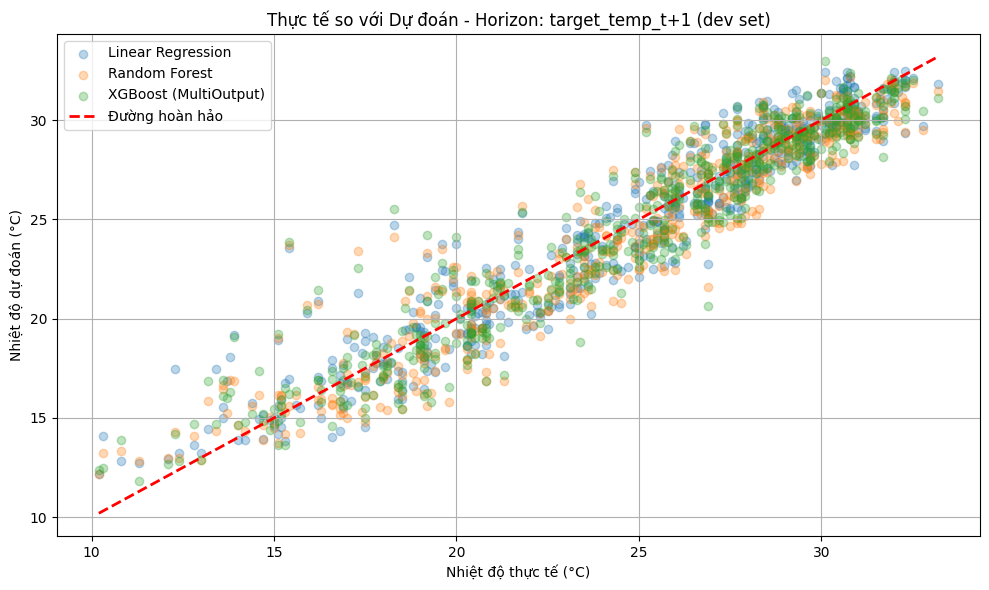

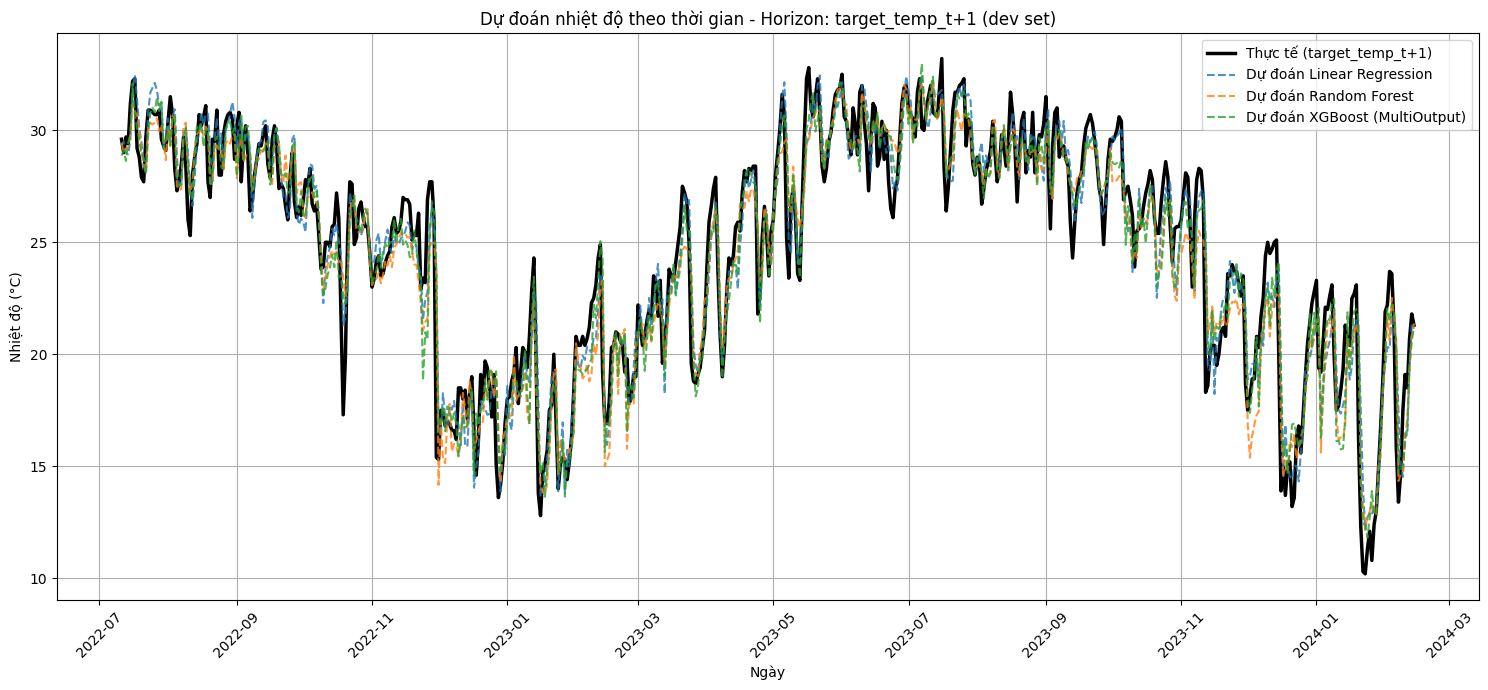

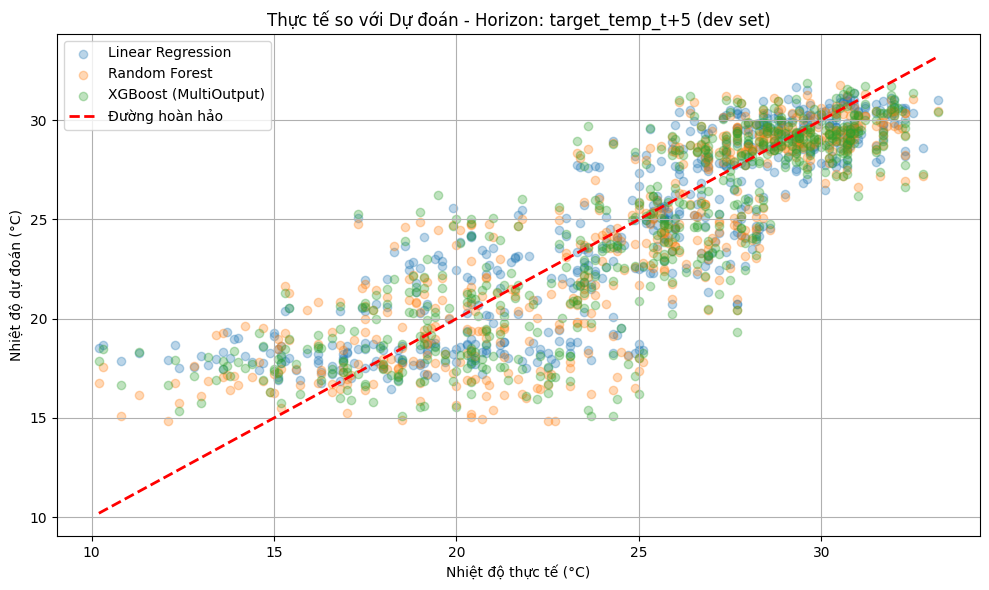

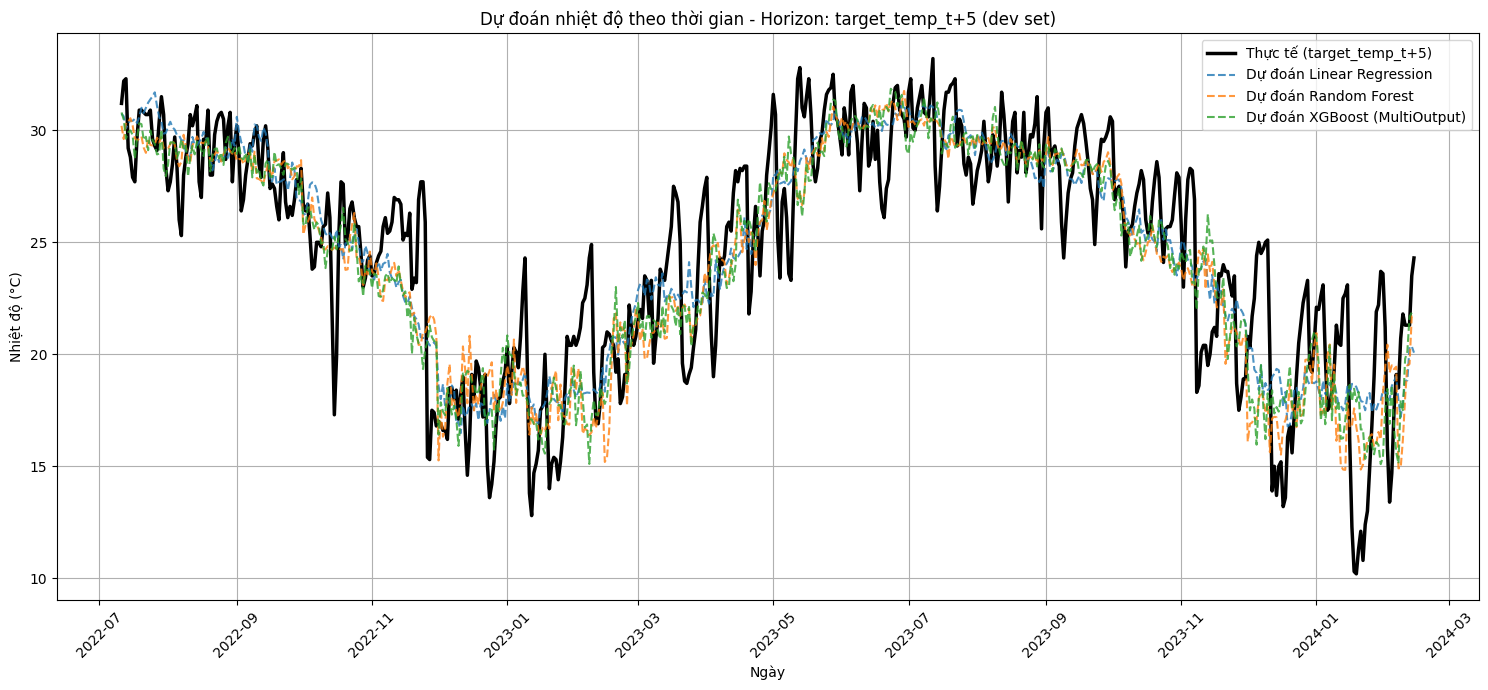


 Tổng hợp kết quả (Metrics) trên tập Development:
                       target_temp_t+1_MAE  target_temp_t+1_RMSE  \
Linear Regression                   1.1685                1.5272   
Random Forest                       1.2915                1.6460   
XGBoost (MultiOutput)               1.1620                1.5563   

                       target_temp_t+2_MAE  target_temp_t+2_RMSE  \
Linear Regression                   1.6681                2.1615   
Random Forest                       1.8011                2.3020   
XGBoost (MultiOutput)               1.7134                2.2508   

                       target_temp_t+3_MAE  target_temp_t+3_RMSE  \
Linear Regression                   1.9236                2.4626   
Random Forest                       2.0796                2.6564   
XGBoost (MultiOutput)               2.0614                2.7148   

                       target_temp_t+4_MAE  target_temp_t+4_RMSE  \
Linear Regression                   1.9752                2.53

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor # Quan trọng: để bọc XGBoost
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_and_evaluate():
    """
    Tải dữ liệu, huấn luyện các mô hình Linear Regression, Random Forest, và XGBoost
    cho dự đoán đa bước (multi-step), đánh giá trên tập development,
    và trực quan hóa kết quả.
    """
    
    # --- 1. Xác định các cột mục tiêu (Horizons) ---
    target_columns = [
        'target_temp_t+1', 
        'target_temp_t+2', 
        'target_temp_t+3', 
        'target_temp_t+4', 
        'target_temp_t+5'
    ]

    print(f"Đang huấn luyện cho {len(target_columns)} horizons: {target_columns}")

    # --- 2. Tải dữ liệu ---
    try:
        X_train = pd.read_csv('processed_data/X_train_transformed.csv', index_col='datetime', parse_dates=True)
        # y_train phải chứa TẤT CẢ các cột trong 'target_columns'
        y_train = pd.read_csv('processed_data/y_train.csv', index_col='datetime', parse_dates=True)

        X_dev = pd.read_csv('processed_data/X_dev_transformed.csv', index_col='datetime', parse_dates=True)
        # y_dev phải chứa TẤT CẢ các cột trong 'target_columns'
        y_dev = pd.read_csv('processed_data/y_dev.csv', index_col='datetime', parse_dates=True)

        # Đảm bảo chỉ giữ lại các cột mục tiêu cần thiết
        y_train = y_train[target_columns]
        y_dev = y_dev[target_columns]

        print(" Tải dữ liệu thành công!")
    except FileNotFoundError as e:
        print(f" Lỗi: Không tìm thấy tệp. Vui lòng kiểm tra lại đường dẫn.")
        print(e)
        return
    except KeyError as e:
        print(f" Lỗi: Không tìm thấy cột mục tiêu trong tệp y_...csv.")
        print(f" Vui lòng kiểm tra lại danh sách 'target_columns' trong code.")
        print(e)
        return

    # --- 3. Khởi tạo mô hình ---
    # LinearRegression và RandomForestRegressor hỗ trợ multi-output tự nhiên.
    # XGBRegressor cần được bọc bằng MultiOutputRegressor.
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(
            n_estimators=200, max_depth=12, min_samples_split=4, 
            random_state=42, n_jobs=-1
        ),
        "XGBoost (MultiOutput)": MultiOutputRegressor(XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
        ))
    }

    # --- 4. Huấn luyện và Đánh giá ---
    results = {}
    # Lưu trữ các dự đoán để vẽ biểu đồ
    all_predictions = {} 

    for name, model in models.items():
        print(f"\n Huấn luyện mô hình: {name} ...")
        # Huấn luyện mô hình để dự đoán TẤT CẢ các cột mục tiêu cùng một lúc
        model.fit(X_train, y_train)
        print(f" Hoàn tất huấn luyện {name}!")

        # y_dev_pred sẽ là một mảng NumPy (n_samples, n_targets)
        y_dev_pred_array = model.predict(X_dev)

        # Chuyển đổi dự đoán thành DataFrame để dễ dàng tính toán và vẽ
        y_dev_pred_df = pd.DataFrame(
            y_dev_pred_array, 
            index=y_dev.index, 
            columns=target_columns
        )
        all_predictions[name] = y_dev_pred_df

        model_results = {}
        print(f"\n--- Hiệu suất (dev set) ({name}) ---")
        
        # Tính toán metrics cho từng horizon
        for horizon in target_columns:
            mae = mean_absolute_error(y_dev[horizon], y_dev_pred_df[horizon])
            mse = mean_squared_error(y_dev[horizon], y_dev_pred_df[horizon])
            rmse = np.sqrt(mse)
            # Lưu trữ metrics theo từng horizon
            model_results[f'{horizon}_MAE'] = mae
            model_results[f'{horizon}_RMSE'] = rmse
            print(f"  {horizon}: MAE = {mae:.4f}, RMSE = {rmse:.4f}")

        # Tính toán metrics trung bình trên tất cả các horizons
        # 'average='weighted' or 'uniform_average'
        avg_mae = mean_absolute_error(y_dev, y_dev_pred_df)
        avg_mse = mean_squared_error(y_dev, y_dev_pred_df)
        avg_rmse = np.sqrt(avg_mse)
        
        model_results["Average_MAE"] = avg_mae
        model_results["Average_RMSE"] = avg_rmse
        print(f"  ---------------------------------")
        print(f"  Average All Horizons: MAE = {avg_mae:.4f}, RMSE = {avg_rmse:.4f}")

        results[name] = model_results

    # --- 5. Trực quan hóa: So sánh các mô hình ---
    print("\n Đang tạo biểu đồ trực quan hóa (so sánh các mô hình)...")

    # Chỉ vẽ biểu đồ cho horizon đầu tiên và cuối cùng để xem
    horizons_to_plot = [target_columns[0], target_columns[-1]]

    for horizon in horizons_to_plot:
        # --- Scatter Plot (Tất cả mô hình trên 1 biểu đồ) ---
        plt.figure(figsize=(10, 6))
        
        for name, y_pred_df in all_predictions.items():
            plt.scatter(y_dev[horizon], y_pred_df[horizon], alpha=0.3, label=name)
        
        # Đường tham chiếu
        min_val = min(y_dev[horizon].min(), y_dev[horizon].min())
        max_val = max(y_dev[horizon].max(), y_dev[horizon].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Đường hoàn hảo')
        
        plt.title(f'Thực tế so với Dự đoán - Horizon: {horizon} (dev set)')
        plt.xlabel('Nhiệt độ thực tế (°C)')
        plt.ylabel('Nhiệt độ dự đoán (°C)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Line Plot (Tất cả mô hình trên 1 biểu đồ) ---
        plt.figure(figsize=(15, 7))
        
        # Vẽ giá trị thực tế
        plt.plot(y_dev.index, y_dev[horizon], label=f'Thực tế ({horizon})', color='black', linewidth=2.5)
        
        # Vẽ dự đoán của từng mô hình
        for name, y_pred_df in all_predictions.items():
            plt.plot(y_dev.index, y_pred_df[horizon], label=f'Dự đoán {name}', linestyle='--', linewidth=1.5, alpha=0.8)
            
        plt.title(f'Dự đoán nhiệt độ theo thời gian - Horizon: {horizon} (dev set)')
        plt.xlabel('Ngày')
        plt.ylabel('Nhiệt độ (°C)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # --- 6. Tổng hợp kết quả ---
    print("\n Tổng hợp kết quả (Metrics) trên tập Development:")
    result_df = pd.DataFrame(results).T
    
    # Sắp xếp các cột để dễ đọc hơn
    cols_ordered = []
    for h in target_columns:
        cols_ordered.append(f'{h}_MAE')
        cols_ordered.append(f'{h}_RMSE')
    cols_ordered.append('Average_MAE')
    cols_ordered.append('Average_RMSE')
    
    # Lọc ra các cột tồn tại trong DataFrame (phòng trường hợp lỗi)
    final_cols = [c for c in cols_ordered if c in result_df.columns]
    
    print(result_df[final_cols].round(4))
    
    # Lưu kết quả ra file
    result_df[final_cols].round(4).to_csv('processed_data/model_evaluation_results.csv')
    print("\nĐã lưu kết quả đánh giá vào 'processed_data/model_evaluation_results.csv'")

if __name__ == '__main__':
    train_and_evaluate()